In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from bliss.datasets import sdss

In [2]:
import sys
sys.path.insert(0, '../sdss_galaxies/')
from sparse_field_lib import load_data

In [3]:
sys.path.insert(0, '../')
import source_simulator_lib
import dataset_lib
from which_device import device

In [4]:
sdss_dir = '/home/runingli/astronomy/celeste/data/sdss/'
psf_file = sdss_dir + '/94/1/12/psField-000094-1-0012.fits'

catalog_file = '../sdss_galaxies/coadd_field_catalog_runjing_liu.fit'

In [5]:
device = 'cuda:4'

# Load data

In [6]:
image, fits_file, wcs_list, sdss_data = load_data(sdss_dir=sdss_dir, 
                                                  catalog_file = catalog_file)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Changed DATE-OBS from '19/09/98' to '1998-09-19''. [astropy.wcs.wcs]


In [7]:
background = sdss_data[0]['background']

In [8]:
# true locations
wcs = wcs_list[0]
px, py = wcs.all_world2pix(fits_file['ra'][:], fits_file['dec'][:], 0)

In [9]:
# true fluxes 
rmags = fits_file['psfmag_r'][:]
nelec_per_nmgy = sdss_data[0]['nelec_per_nmgy'].mean()
rfluxes = dataset_lib._convert_mag_to_nmgy(rmags) * nelec_per_nmgy

In [10]:
# galaxy / star classification 
is_star = fits_file['probpsf'][:] == 1

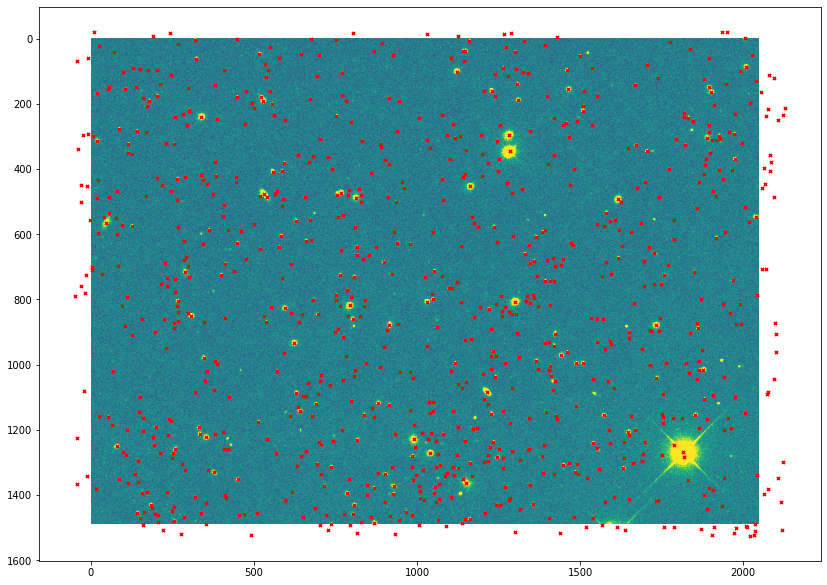

In [11]:
%matplotlib inline
plt.figure(figsize=(14,14))
vmin = np.percentile(image.flatten(), 1)
vmax = np.percentile(image.flatten(), 99)

plt.imshow(image[0], vmin=vmin, vmax=vmax)
plt.scatter(px, py, marker='x', color='r', s=10)

# Load PSF

In [12]:
sdss_psf = sdss.SdssPSF(psf_file, [2])

psf = sdss_psf.psf_at_points(0, 0., 0.)

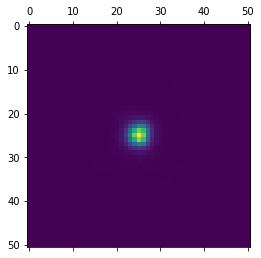

In [13]:
plt.matshow(psf)

# Let us consider a small chuck

In [14]:
# clen = 200

# x0 = 450
# y0 = 350

clen = 50
x0 = 100
y0 = 310

xlim = (x0, x0 + clen)
ylim = (y0, y0 + clen)
print('coordinates: ', xlim, ylim)

image_chunk = image[0, ylim[0]:ylim[1], xlim[0]:xlim[1]]
background_chunk = background[0, ylim[0]:ylim[1], xlim[0]:xlim[1]]

# restrict to 200x200 chunk 
keep = (px > xlim[0]) & (px < xlim[1]) & (py < ylim[1]) & (py > ylim[0])

print('n sources: ', keep.sum())

coordinates:  (100, 150) (310, 360)
n sources:  3


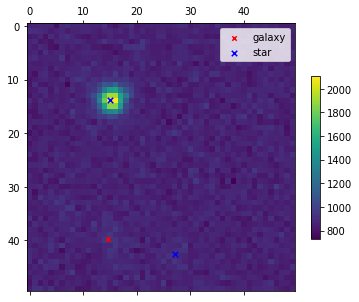

In [15]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))


p_level = 0.0
vmin = np.percentile(image_chunk.flatten(), p_level)
vmax = np.percentile(image_chunk.flatten(), 100-p_level)

# coordinates in the chunk
c_px = px[keep] - xlim[0]
c_py = py[keep] - ylim[0]

c_is_star = is_star[keep]

# and show it with correct centers.
im = ax.matshow(image_chunk, vmin=vmin, vmax=vmax)
ax.scatter(c_px[~c_is_star], c_py[~c_is_star], marker='x', color='r', s=20, label = 'galaxy')
ax.scatter(c_px[c_is_star], c_py[c_is_star], marker='x', color='b', s=30, label = 'star')
fig.colorbar(im, ax=ax, shrink=0.5)
ax.legend()

# Use my simulator to get the actual catalog

In [16]:
# the locations from the catalog
fx = (c_px) / (clen - 1)
fy = (c_py) / (clen - 1)

# (1 x n_sources x 3)
sdss_chunk_locs = torch.Tensor([fy, fx]).transpose(0, 1).unsqueeze(0).to(device)

In [17]:
# the fluxes
sdss_chunk_fluxes = torch.Tensor([rfluxes[keep]]).unsqueeze(-1).to(device)

In [18]:
# the star and galaxy booleans
star_bool = torch.Tensor(c_is_star).unsqueeze(0).unsqueeze(-1).to(device)
gal_bool = torch.Tensor(1 - c_is_star).unsqueeze(0).unsqueeze(-1).to(device)

In [19]:
_psf = torch.Tensor(psf).unsqueeze(0).to(device)

source_simulator = source_simulator_lib.SourceSimulator(psf = _psf, 
                                                        tile_slen = clen, 
                                                        ptile_slen = clen)

In [20]:
import catalog_optimizer_lib

In [21]:
my_catalog = catalog_optimizer_lib.CatalogParameters(sdss_chunk_locs.contiguous(), 
                                                     torch.log(sdss_chunk_fluxes).contiguous()).to(device)

In [22]:
_background_chunk = torch.Tensor(background_chunk).to(device).unsqueeze(0).unsqueeze(0)
_image_chunk = image_chunk.to(device).unsqueeze(0).unsqueeze(0)


In [23]:
loss, recon_mean = catalog_optimizer_lib.get_loss(_image_chunk, 
                               _background_chunk,
                               source_simulator,
                               my_catalog,
                               star_bool, 
                               gal_bool)

print(loss)

tensor(5.0775, device='cuda:4', grad_fn=<NegBackward>)


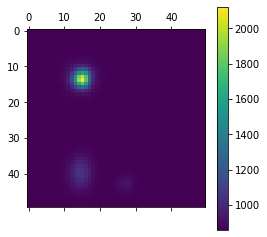

In [24]:
plt.matshow(recon_mean[0, 0].detach().cpu())
plt.colorbar()

In [25]:
catalog_optimizer_lib.estimate_catalog(_image_chunk, 
                                       _background_chunk,
                                       source_simulator,
                                       my_catalog,
                                       star_bool, 
                                       gal_bool, 
                                       lr = 1,
                                       print_every = True)

tensor(5.0775, device='cuda:4', grad_fn=<NegBackward>)
tensor(4.8640, device='cuda:4', grad_fn=<NegBackward>)
tensor(4.8640, device='cuda:4', grad_fn=<NegBackward>)
tensor(4.8640, device='cuda:4', grad_fn=<NegBackward>)


In [26]:
my_catalog.get_galaxy_params()

{'flux': tensor([[[23959.2168],
          [  345.5913],
          [ 1256.4714]]], device='cuda:4', grad_fn=<ExpBackward>),
 'theta': tensor([[[3.1416],
          [2.8652],
          [3.1416]]], device='cuda:4', grad_fn=<MulBackward0>),
 'ell': tensor([[[0.5000],
          [0.0764],
          [0.5000]]], device='cuda:4', grad_fn=<SigmoidBackward>),
 'rad': tensor([[[1.0000],
          [0.1870],
          [1.0000]]], device='cuda:4', grad_fn=<ExpBackward>)}

In [27]:
_image_chunk.shape

torch.Size([1, 1, 50, 50])

In [28]:
recon_mean.shape

torch.Size([1, 1, 50, 50])

In [29]:
loss, recon_mean = catalog_optimizer_lib.get_loss(_image_chunk, 
                               _background_chunk,
                               source_simulator,
                               my_catalog,
                               star_bool, 
                               gal_bool)

print(loss)

tensor(4.8640, device='cuda:4', grad_fn=<NegBackward>)


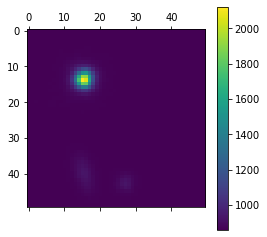

In [30]:
plt.matshow(recon_mean[0, 0].detach().cpu())
plt.colorbar()

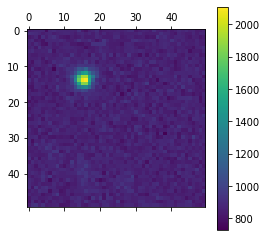

In [31]:
plt.matshow(_image_chunk[0, 0].detach().cpu())
plt.colorbar()

In [36]:
stars = source_simulator.render_stars(sdss_chunk_locs, 
                                      my_catalog.get_star_params(), 
                                      star_bool)

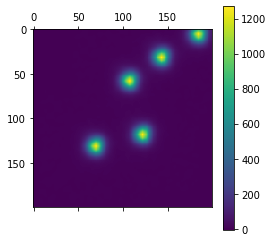

In [37]:
plt.matshow(stars[0, 0].detach().cpu())
plt.colorbar()

In [29]:
galaxies = source_simulator.render_galaxies(sdss_chunk_locs, 
                                            my_catalog.get_galaxy_params(), 
                                            gal_bool)

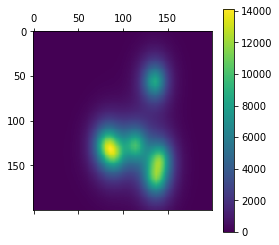

In [31]:
plt.matshow(galaxies[0, 0].detach().cpu())
plt.colorbar()

In [32]:
np.exp(10)

22026.465794806718

In [ ]:
_background = torch.Tensor(background_chunk).to(device).unsqueeze(0).unsqueeze(0)
_image_chunk = image_chunk.to(device).unsqueeze(0).unsqueeze(0)

get_loss(_image_chunk, _background, my_catalog, star_bool, gal_bool)

In [ ]:
background_chunk

In [ ]:
background_chunk.shape

In [ ]:
background_chunk.shape

In [ ]:
background

In [ ]:
def run_lbfgs(loss_fun, 
              catalog_params, 
              max_outer_iter = 10,
              max_inner_iter = 50,
              tol = 1e-8,
              print_every = False): 

    optimizer = optim.LBFGS(catalog_params.parameters(), 
                            max_iter = max_inner_iter,
                            line_search_fn = 'strong_wolfe')
    
    def closure():
        optimizer.zero_grad()
        loss = loss_fun(*catalog_params.forward())
        loss.backward()
        
        return loss
    
    init_loss = closure()
    
    old_loss = 1e16
    for i in range(max_outer_iter):
        loss = optimizer.step(closure)

        if print_every:
            print(loss)

        diff = (loss - old_loss).abs()
        if diff < (tol * init_loss.abs()):
            break

        old_loss = loss
        
